# Análise de Dados Soccer2D

## Introdução

Esta oficina proporcionará uma introdução prática e direta à análise descritiva de dados no contexto de futebol de robôs, utilizando dados coletados de partidas da RoboCup Soccer Simulation 2D, que é uma competição em que dois times de 11 robôs autônomos simulados joguem uma partida de futebol contra outros times.

Caso deseje rodar este notebook no ambiente do Colab, basta fazer o upload de todo o diretório e descomentar a célula abaixo, **ajustando o path com a localização do diretório no Drive ;)**

In [1]:
# # permite o acesso aos dados
# from google.colab import drive
# drive.mount('/content/drive/')

## Objetivos

1. Processar os dados de uma partida;
2. Visualizar os dados processados;
3. Identificar algumas das estratégias e o estilo de jogo de ambas as equipes;

Antes de iniciarmos as análises, nós precisamos que algumas bibliotecas já estejam disponíveis. São elas:

- [Numpy](http://www.numpy.org/) para todas as operações matriciais;
- [Matplotlib](https://matplotlib.org/) para a plotagem dos gráficos;
- [Pandas](https://pandas.pydata.org/docs/index.html) que contém funções e ferramentas de manipulação e visualização de dados.
- [Scikit-learn](https://scikit-learn.org/stable/index.html) para utilização de algoritmos de machine learning e outras funções úteis.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## 1. Exploração dos dados

Nesta etapa, carregaremos o dataset e, em seguida, detalharemos as informações que ele possui.

In [3]:
# ajuste o path para a localização do arquivo csv
df = pd.read_csv('data/Oxsy_1-vs-YuShan2023_3.csv')

In [4]:
# visualizando os dados
df.head()

,show_time,playmode,team_name_l,team_name_r,team_score_l,team_score_r,team_pen_score_l,team_pen_score_r,team_pen_miss_l,team_pen_miss_r,...,player_r11_vx,player_r11_vy,player_r11_body,player_r11_neck,player_r11_attribute_stamina,player_r11_attribute_stamina_capacity,player_r11_counting_kick,player_r11_counting_dash,player_r11_counting_catch,player_r11_counting_tackle
0,1,kick_off_l,Oxsy,YuShan2023,0,0,0,0,0,0,...,-0.0865,0.0004,138.132,26,7979.40,130559.0,0,1,0,0
1,2,kick_off_l,Oxsy,YuShan2023,0,0,0,0,0,0,...,-0.0847,-0.0353,138.132,-39,7958.96,130518.0,0,2,0,0
2,3,kick_off_l,Oxsy,YuShan2023,0,0,0,0,0,0,...,-0.0297,-0.0113,7.263,90,8000.00,130477.0,0,2,0,0
3,4,kick_off_l,Oxsy,YuShan2023,0,0,0,0,0,0,...,-0.0107,-0.0039,7.263,90,8000.00,130477.0,0,2,0,0
4,5,kick_off_l,Oxsy,YuShan2023,0,0,0,0,0,0,...,-0.0036,-0.0017,7.263,90,8000.00,130477.0,0,2,0,0


In [5]:
# visualizando todas as colunas e uma lista
df.columns.to_list()

['show_time',
 'playmode',
 'team_name_l',
 'team_name_r',
 'team_score_l',
 'team_score_r',
 'team_pen_score_l',
 'team_pen_score_r',
 'team_pen_miss_l',
 'team_pen_miss_r',
 'ball_x',
 'ball_y',
 'ball_vx',
 'ball_vy',
 'player_l1_unum',
 'player_l1_type',
 'player_l1_x',
 'player_l1_y',
 'player_l1_vx',
 'player_l1_vy',
 'player_l1_body',
 'player_l1_neck',
 'player_l1_attribute_stamina',
 'player_l1_attribute_stamina_capacity',
 'player_l1_counting_kick',
 'player_l1_counting_dash',
 'player_l1_counting_catch',
 'player_l1_counting_tackle',
 'player_l2_unum',
 'player_l2_type',
 'player_l2_x',
 'player_l2_y',
 'player_l2_vx',
 'player_l2_vy',
 'player_l2_body',
 'player_l2_neck',
 'player_l2_attribute_stamina',
 'player_l2_attribute_stamina_capacity',
 'player_l2_counting_kick',
 'player_l2_counting_dash',
 'player_l2_counting_catch',
 'player_l2_counting_tackle',
 'player_l3_unum',
 'player_l3_type',
 'player_l3_x',
 'player_l3_y',
 'player_l3_vx',
 'player_l3_vy',
 'player_l3_bod

As colunas do dataset contém informações acerca da partida e de cada um dos jogadores de cada time. Algumas das colunas que utilizaremos nesta análise podem ser descritas da seguinte forma:

partida:
- show_time: ciclo do servidor (~ 0.1 segundo)
- playmode: estado atual do jogo (escanteio, pênalti, falta, etc)
- team_name_[LADO]: nome do time que está em cada lado
- team_score_[LADO]: gols de cada time
- team_pen_score_[LADO]: gols de pênalti
- team_pen_miss_[LADO]: gols de pênalti perdidos
- ball_[COORD]: coordenada x ou y da bola
- ball_v[COORD]: velocidade da bola no eixo x ou y

jogadores:
- player_[LADO][NUM_JOG]_unum: número da camisa do jogador. 0 significa que o jogador está desativado 
- player_[LADO][NUM_JOG]_type: id do tipo de cada jogador (meio-campista, defensor, goleiro, etc.)
- player_[LADO][NUM_JOG][COORD]: coordenada x ou y do jogador
- player_[LADO][NUM_JOG]_v[COORD]: velocidade do jogador
- player_[LADO][NUM_JOG]_body: angulação do corpo do jogador, variando no intervalo de (-180, 180) graus
- player_[LADO][NUM_JOG]_neck: angulação do pescoço do jogador, variando no intervalo de (-90, 90) graus
- player_[LADO][NUM_JOG]_attribute_stamina: nível atual de stamina do jogador
- player_[LADO][NUM_JOG]_attribute_stamina_capacity: capacidade total de stamina do jogador
- player_[LADO][NUM_JOG]_counting_kick: quantidade de chutes do jogador
- player_[LADO][NUM_JOG]_counting_dash: quantidade de carrinhos realizados pelo jogador
- player_[LADO][NUM_JOG]_counting_catch: quantidade de bolas agarradas pelo goleiro (para outros jogadores será sempre 0)
- player_[LADO][NUM_JOG]_counting_tackle: quantidade de bolas tomadas pelo do jogador

Além dos dados descritos acima, há informações sobre atributos dos jogadores e contagem do número de ações de cada jogador, como faltas, chutes, defesas, etc.

A coluna `playmode` descreve modos do jogo que podem ocorrer durante a partida. Cada modo corresponde à um evento, semelhante ao futebol da vida real.

In [6]:
df['playmode'].unique()

array(['kick_off_l', 'play_on', 'kick_in_r', 'goal_r', 'foul_charge_l',
       'free_kick_r', 'kick_in_l', 'goal_l', 'kick_off_r', 'offside_r',
       'free_kick_l', 'foul_charge_r', 'goal_kick_r', 'goal_kick_l',
       'corner_kick_l', 'time_over'], dtype=object)

Segue a descrição de cada modo de jogo:

- **kick_off_[LADO]**: Início da partida com o time à esquerda ou direita dando o pontapé inicial.
- **play_on**: O jogo está em andamento normalmente, sem interrupções.
- **kick_in_[LADO]**: O time à direita ou esquerda executa um arremesso lateral.
- **goal_[LADO]**: Gol marcado pelo time à direita ou esquerda.
- **foul_charge_[LADO]**: Falta cometida pelo time à esquerda ou direita por carga irregular.
- **free_kick_[LADO]**: Cobrança de falta para o time à direita ou esquerda.
- **kick_off_[LADO]**: Início da partida ou reinício com o time à direita ou esquerda dando o pontapé inicial.
- **offside_[LADO]**: Impedimento do time à direita ou esquerda.
- **goal_kick_[LADO]**: Tiro de meta cobrado pelo time à direita ou esquerda.
- **corner_kick_[LADO]**: Cobrança de escanteio pelo time à esquerda ou direita.
- **time_over**: O tempo regulamentar do jogo terminou.

## 3. Processando os dados

### 3.1 Funções e classes auxiliares

Antes de começarmos a análise, vale definir algumas funções e classes que podem ser úteis durante o processo.

Para simplificar, optamos por criar um arquivo chamado `geom_2d` que contém implementação de abstrações geométricas, como o ponto e o círculo, além de funções como o cálculo de distância entre dois pontos.

Também criamos funções auxiliares no arquivo `helpers.py` que irão extrair e processar dados úteis a partir dos dados coletados, como estimar a posse de bola a partir da posição dos jogadores.

No entanto, recomendamos fortemente que você abra e entenda o código desses arquivos para ampliar o seu entendimento da análise como um todo. Todos os códigos disponibilizados foram implementados e comentados para que o seu entendimento seja facilitado.

In [7]:
from geom_2d import Point, Circle, distance
from helpers import *

Para reunir todos os dados processados que obteremos nesta etapa, criaremos um novo dataset.

In [8]:
game_stats = pd.DataFrame()

#### Posse de bola

Para calcular a posse de bola, basta calcular a porcentagem do tempo total em que um determinado time esteve com a bola.

$$P_{t} = \frac{T_{t}}{T_{Total}} * 100$$

Consideraremos que o time mais próximo da bola terá o domínio.

In [9]:
# colunas referentes às coordenadas de cada jogador
players_left = []
players_right = []
for i in range(1, 12):
    players_left.append((f'player_l{i}_x', f'player_l{i}_y'))
    players_right.append((f'player_r{i}_x', f'player_r{i}_y'))
players = [players_left, players_right]

Para o cálculo do tempo em que cada time esteve com a posse da bola, iremos iterar por cada ciclo do servidor, contando os ciclos em que cada time esteve sob o domínio da bola. 

Utilizaremos a função `possession_at` para determinar de quem é a posse a cada ciclo. A implementação desta função se encontra no arquivo `helpers.py`. 

In [10]:
# momentos em que o jogo não estava parado
filtered_game = df[df['playmode'] == 'play_on']

# inicializa os contadores de tempo
time_left = time_right = 0

# inicializa uma lista para armazenar a posse a cada instante
possession_data = []

for cycle, row in filtered_game.iterrows():
  # função auxiliar possession_at() para determinar a posse
  possession_side = possession_at(cycle, filtered_game, players)

  if possession_side == 'left':
    time_left += 1
  else:
    time_right += 1

  # cálculo das posses
  total_time = time_left + time_right
  possession_left = time_left/ total_time
  possession_right = time_right/ total_time

  # armazena a posse a cada instante
  possession_data.append({'cycle': cycle, 'possession_l': possession_left, 'possession_r': possession_right})

# converte a lista para um DataFrame e adiciona ao game_stats
possession_df = pd.DataFrame(possession_data)
game_stats = pd.concat([game_stats, possession_df], axis=1)

team_name_left = df['team_name_l'][0]
team_name_right = df['team_name_r'][0]

# posse no formato tabelado
possession_summary = pd.DataFrame({
  'Time': [team_name_left, team_name_right],
  'Posse (%)': [possession_left * 100, possession_right * 100]
})

print("Posse de bola")
print("==========================")
print(possession_summary.to_string(index=False))
print("==========================")

Posse de bola
      Time  Posse (%)
      Oxsy   37.50306
YuShan2023   62.49694


Podemos gerar visualizações da posse de bola para extrair insights úteis

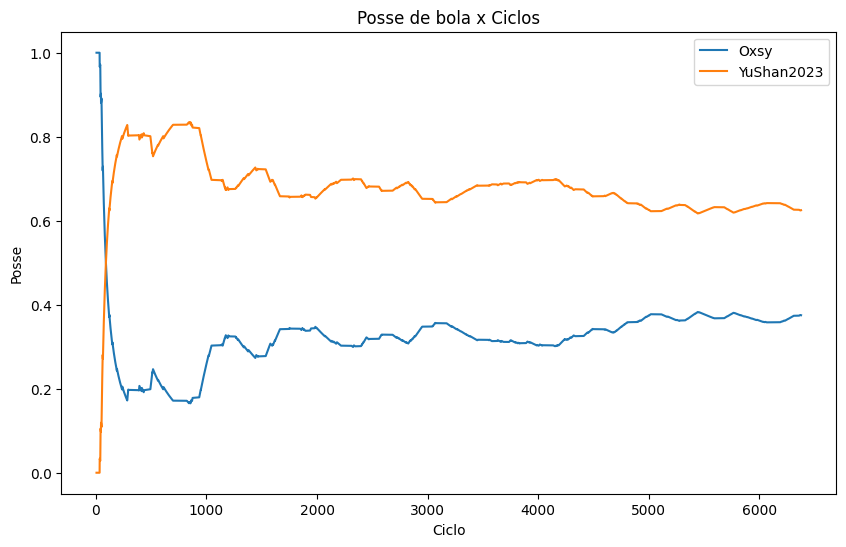

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(game_stats['cycle'], game_stats['possession_l'], label=team_name_left)
plt.plot(game_stats['cycle'], game_stats['possession_r'], label=team_name_right)
plt.xlabel('Ciclo')
plt.ylabel('Posse')
plt.title('Posse de bola x Ciclos')
plt.legend(loc='upper right')
plt.show()

A ocorrência de gols alteraram a posse de bola de cada time?

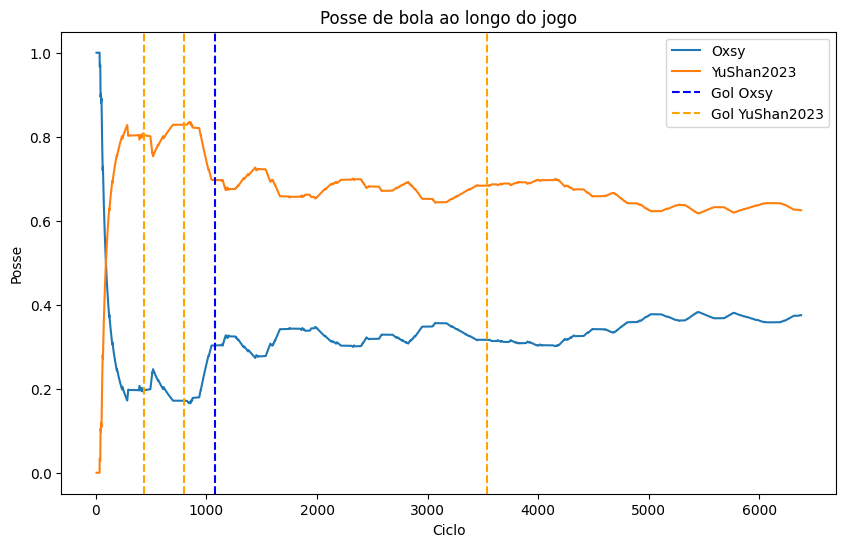

In [12]:
# Ciclos em que um gol ocorreu
goal_cycles_l = df[df['playmode'] == 'goal_l']['show_time'].unique()
goal_cycles_r = df[df['playmode'] == 'goal_r']['show_time'].unique()

plt.figure(figsize=(10, 6))
plt.plot(game_stats['cycle'], game_stats['possession_l'], label=team_name_left)
plt.plot(game_stats['cycle'], game_stats['possession_r'], label=team_name_right)

# indica o ciclo em que um dos dois times marcaram gols
for cycle in goal_cycles_l:
    plt.axvline(x=cycle, color='blue', linestyle='--', label=f'Gol {team_name_left}')

for cycle in goal_cycles_r:
    plt.axvline(x=cycle, color='orange', linestyle='--', label=f'Gol {team_name_right}')

# remove legendas duplicadas
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel('Ciclo')
plt.ylabel('Posse')
plt.title('Posse de bola ao longo do jogo')
plt.show()

É possível perceber que o time *Yushan2023* manteve a posse de bola elevada no início do jogo, no momento em que ele 

#### Passes

Para contabilizar os passes de cada time, precisaremos iterar por cada ciclo do servidor, monitorando os passes e mudanças de posse de bola, enquanto rastreamos o número de passes corretos, errados e interceptados para ambos os times.

**Para cada ciclo do jogo**:
- Verifica-se se um jogador do time direito ou esquerdo fez um passe.
- Se um passe está em andamento, determinamos a posse da bola e atualizamos os contadores de passes corretos, errados ou interceptados com base na continuidade ou interrupção da posse.
- Para passes interceptados, verifica-se se houve interrupções no jogo (`kick_off` ou `foul_charge`) nos ciclos seguintes, ajustando o contador se necessário.

O objetivo final é contabilizar a eficácia dos passes e a frequência de interceptações durante o jogo.

In [13]:
# time esquerdo
correct_passes_l, wrong_passes_l, intercepted_passes_l = analyse_passes(df, players, team_name_left)

# time direito
correct_passes_r, wrong_passes_r, intercepted_passes_r = analyse_passes(df, players, team_name_right)

Ao final do loop, basta calcular a precisão dos passes e mostar os resultados.

In [14]:

# Calcula o total de passes e a precisão de passes para ambos os times
left_team_total_passes = correct_passes_l + wrong_passes_l + intercepted_passes_r
right_team_total_passes = correct_passes_r + wrong_passes_r + intercepted_passes_l

left_team_passing_accuracy = correct_passes_l / left_team_total_passes
right_team_passing_accuracy = correct_passes_r / right_team_total_passes

# Atribui os valores finais para passes completos e interceptações
left_team_completed_passes = correct_passes_l
right_team_completed_passes = correct_passes_r

left_team_interceptions = intercepted_passes_l
right_team_interceptions = intercepted_passes_r

print(
f"""
==========================
{team_name_left}

passes totais: {left_team_total_passes}
passes completos: {left_team_completed_passes}
acurácia: {left_team_passing_accuracy:.2f}
interceptações: {left_team_interceptions}

==========================
{team_name_right}

passes totais: {right_team_total_passes}
passes completos: {right_team_completed_passes}
acurácia: {right_team_passing_accuracy:.2f}
interceptações: {right_team_interceptions}

===========================
"""
)


Oxsy

passes totais: 122
passes completos: 104
acurácia: 0.85
interceptações: 20

YuShan2023

passes totais: 276
passes completos: 253
acurácia: 0.92
interceptações: 17




Com base nos dados obtidos nas células anteriores, podemos comparar a distribuição de passes de cada time.

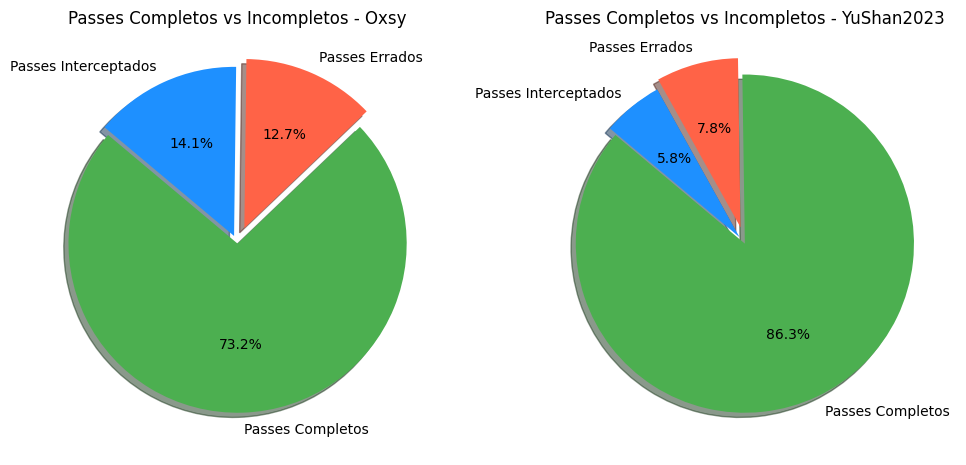

In [15]:
# quantidade de passes incompletos
left_team_incompleted_passes = left_team_total_passes - left_team_completed_passes
right_team_incompleted_passes = right_team_total_passes - right_team_completed_passes

# parâmetros do gráfico 
labels = ['Passes Completos', 'Passes Errados', 'Passes Interceptados']
explode = (0, 0.1, 0.05) # destaca a fatia de passes incompletos
colors = ['#4CAF50', '#FF6347', '#1E90FF']

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# gráfico de pizza para o time esquerdo
sizes = [left_team_completed_passes, left_team_incompleted_passes, intercepted_passes_l]
axs[0].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
axs[0].set_title(f'Passes Completos vs Incompletos - {team_name_left}')

# gráfico de pizza para o time direito
sizes_right = [right_team_completed_passes, right_team_incompleted_passes, intercepted_passes_r]
axs[1].pie(sizes_right, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
axs[1].set_title(f'Passes Completos vs Incompletos - {team_name_right}')

plt.show()

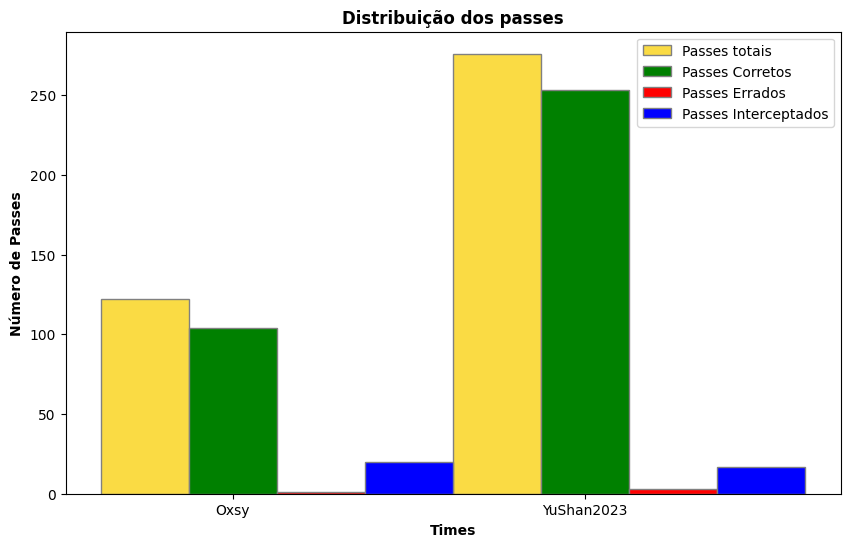

In [16]:
# dados a serem mostrados no histograma
passes_data = {
    'Passes Corretos': [correct_passes_l, correct_passes_r],
    'Passes Errados': [wrong_passes_l, wrong_passes_r],
    'Passes Interceptados': [intercepted_passes_l, intercepted_passes_r]
}

# nome dos times
teams = [team_name_left, team_name_right]

# plotando o histograma
fig, ax = plt.subplots(figsize=(10, 6))

# tamanho da barra
bar_width = 0.25

# posição das barras no eixo x
r1 = np.arange(len(passes_data['Passes Corretos']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# passes totais
total_passes = [left_team_total_passes, right_team_total_passes]
r4 = [x + bar_width for x in r3]

# criando as barras
ax.bar(r1, total_passes, color='#fadb44', width=bar_width, edgecolor='grey', label='Passes totais')
ax.bar(r2, passes_data['Passes Corretos'], color='g', width=bar_width, edgecolor='grey', label='Passes Corretos')
ax.bar(r3, passes_data['Passes Errados'], color='r', width=bar_width, edgecolor='grey', label='Passes Errados')
ax.bar(r4, passes_data['Passes Interceptados'], color='b', width=bar_width, edgecolor='grey', label='Passes Interceptados')

# labels
ax.set_xlabel('Times', fontweight='bold')
ax.set_ylabel('Número de Passes', fontweight='bold')
ax.set_title('Distribuição dos passes', fontweight='bold')
ax.set_xticks([r + bar_width for r in range(len(passes_data['Passes Corretos']))])
ax.set_xticklabels(teams)

ax.legend()

plt.show()

### Escanteios

Como comentado anteriormente, a coluna `playmode` especifica os estados do jogo a cada ciclo. Podemos contar a ocorrência única de cada um desses estados durante o jogo por meio da função `find_last_unique_event_ocurrences`.

In [17]:
# retorna uma lista com o ciclo em que o escanteio ocorreu para cada time
left_occurrencies = find_last_unique_event_ocurrences(df, "corner_kick_l")
right_occurrencies = find_last_unique_event_ocurrences(df, "corner_kick_r")

print(f"momentos dos escanteios do time esquerdo: {left_occurrencies}")
print("==================================================")
print(f"momentos dos escanteios do time direito: {right_occurrencies}")

momentos dos escanteios do time esquerdo: [6358]
momentos dos escanteios do time direito: []


### Faltas

Para analisar as faltas, iremos iterar por cada ciclo, verificando se uma falta ocorreu. Caso positivo, iremos armazenar o local onde cada falta ocorreu. A função `analyze_fouls` encapsula essa lógica. 

In [18]:
left_charges, right_charges = analyze_fouls(df)

print("posições das faltas do time esquerdo:")
for f in left_charges:
    print(f)

print("posições das faltas do time direito:")
for f in right_charges:
    print(f)

posições das faltas do time esquerdo:
x: -51 - y: -29
posições das faltas do time direito:
x: 38 - y: -25
x: 23 - y: -27


Podemos visualizar graficamente as posições das faltas no campo utilizado pela competição.

![Field Landmarks](images/landmarks.png)

Note que podemos utilizar as marcações do campo acima, por meio da classe `landmarks`, que lista algumas delas. 

In [19]:
from landmarks import Landmarks

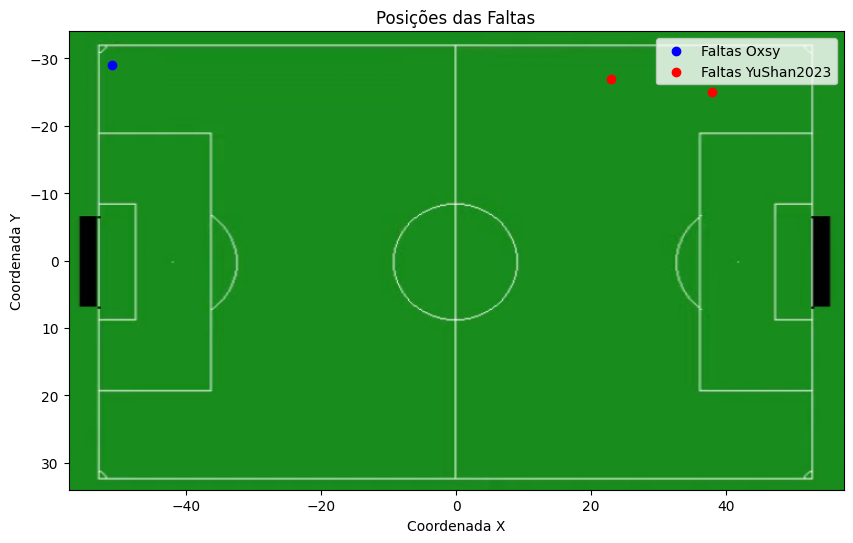

In [20]:
# Carrega a imagem do campo
field_img = plt.imread('images/sim2d_field.png')

fig, ax = plt.subplots(figsize=(10, 6))

# Limites do campo
left = -57.5
right = 57.5
top = 34.
bottom = -34.
limits = [left, right, top, bottom]

# Imagem do campo
ax.imshow(field_img, extent=limits)

# Posições das faltas
left_charge_positions = [(charge.x, charge.y) for charge in left_charges]
right_charge_positions = [(charge.x, charge.y) for charge in right_charges]

# Plot
if left_charge_positions:
    left_x, left_y = zip(*left_charge_positions)
    ax.scatter(left_x, left_y, color='blue', label=f'Faltas {team_name_left}')

if right_charge_positions:
    right_x, right_y = zip(*right_charge_positions)
    ax.scatter(right_x, right_y, color='red', label=f'Faltas {team_name_right}')

# Set labels and title
ax.set_xlabel('Coordenada X')
ax.set_ylabel('Coordenada Y')
ax.set_title('Posições das Faltas')
ax.legend()

# Show the plot
plt.show()

### Defesas do Goleiro

Podemos analisar o desempenho dos goleiros de cada time por meio da função `analyse_goalkeeper`, que irá extrair a quantidade de defesas, gols concedidos, a distância do goleiro para a bola e a posição de ambos, respectivamente.

In [21]:
catches_l, goals_r, distances_l, ball_positions_l, goalie_positions_l = analyze_goalkeeper(df, players, team_name_left)
catches_r, goals_l, distances_r, ball_positions_r, goalie_positions_r = analyze_goalkeeper(df, players, team_name_right)

print(
    f"""
    Team {team_name_left} goalie's stats:

    catches: {catches_l}
    goals given: {goals_r}
    distances of the goalkeeper from the ball: {distances_l}
    positions of the goalie when the goals occured: {goalie_positions_l}
    positions of the ball when the goals occured: {ball_positions_l}

    ====================================================================
    
    Team {team_name_right} goalie's stats:

    catches: {catches_r}
    goals given: {goals_l}
    distances of the goalkeeper from the ball: {distances_r}
    positions of the goalie when the goals occured: {goalie_positions_r}
    positions of the ball when the goals occured: {ball_positions_r}
    """    
)


    Team Oxsy goalie's stats:

    catches: 1
    goals given: 3
    distances of the goalkeeper from the ball: [87.72708769234278, 89.55876060107128, 88.9113992716907]
    positions of the goalie when the goals occured: [<geom_2d.Point object at 0x707dccae89d0>, <geom_2d.Point object at 0x707dccad1c90>, <geom_2d.Point object at 0x707dccaa2aa0>]
    positions of the ball when the goals occured: [<geom_2d.Point object at 0x707dccae93f0>, <geom_2d.Point object at 0x707dccaea020>, <geom_2d.Point object at 0x707dccaa2440>]

    
    Team YuShan2023 goalie's stats:

    catches: 2
    goals given: 1
    distances of the goalkeeper from the ball: [88.21718849096246]
    positions of the goalie when the goals occured: [<geom_2d.Point object at 0x707dccaebfd0>]
    positions of the ball when the goals occured: [<geom_2d.Point object at 0x707dccaa2a40>]
    


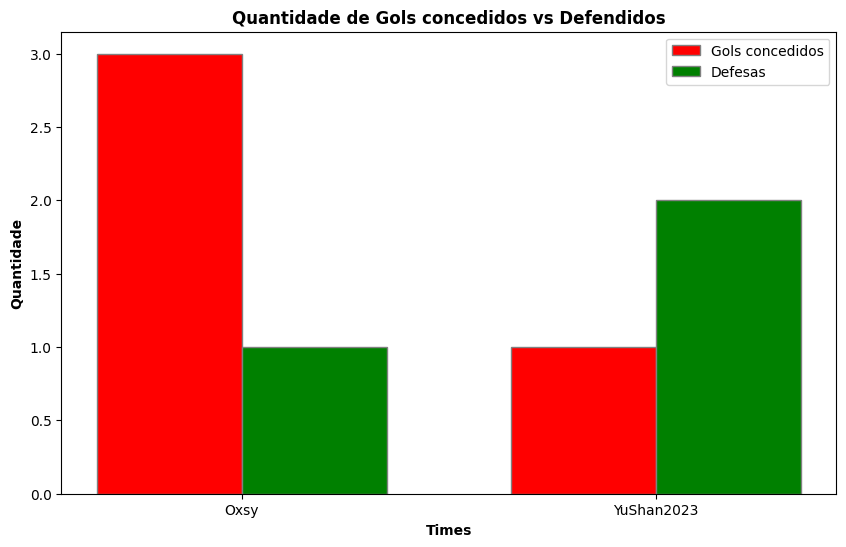

In [22]:
# Quantidade de gols concedidos vs defesas
left_team_goals_given = goals_r
left_team_catches = catches_l

right_team_goals_given = goals_l
right_team_catches = catches_r

# Dados a serem plotados
teams = [team_name_left, team_name_right]
goals_given = [left_team_goals_given, right_team_goals_given]
catches = [left_team_catches, right_team_catches]

# Histograma
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
r1 = np.arange(len(teams))
r2 = [x + bar_width for x in r1]

ax.bar(r1, goals_given, color='r', width=bar_width, edgecolor='grey', label='Gols concedidos')
ax.bar(r2, catches, color='g', width=bar_width, edgecolor='grey', label='Defesas')

ax.set_xlabel('Times', fontweight='bold')
ax.set_ylabel('Quantidade', fontweight='bold')
ax.set_title('Quantidade de Gols concedidos vs Defendidos', fontweight='bold')
ax.set_xticks([r + bar_width / 2 for r in range(len(teams))])
ax.set_xticklabels(teams)

ax.legend()

plt.show()


### Chutes a gol

Para a extração da quantidade de chutes a gols, utilizaremos uma estratégia semelhante à extração de dados anteriores, como faltas, escanteios e passes.

Desse modo, utilizaremos a classe `Shooting`, que reúne todos os métodos e estatísticas relacionados à chutes a gol.

In [23]:
from shooting import Shooting

In [24]:
shoot_analyser = Shooting(df)

# time esquerdo
shots_l = shoot_analyser.get_total_team_shots('l')
shots_on_target_l = shoot_analyser.get_team_on_target_shots('l')

# time direito
shots_r = shoot_analyser.get_total_team_shots('r')
shots_on_target_r = shoot_analyser.get_team_on_target_shots('r')

print(
    f""" 
    Team {df['team_name_l'][0]} shot stats:

    total shots: {shots_l}
    shots on target: {shots_on_target_l}
    accuracy: {shots_on_target_l/shots_l * 100:.1f}
    
    ==========================================
    
    Team {df['team_name_r'][0]} shot stats:

    total shots: {shots_r}
    shots on target: {shots_on_target_r}
    accuracy: {shots_on_target_r/shots_r * 100:.1f}
    """
)

 
    Team Oxsy shot stats:

    total shots: 10
    shots on target: 7
    accuracy: 70.0
    
    
    Team YuShan2023 shot stats:

    total shots: 12
    shots on target: 7
    accuracy: 58.3
    


### Gols esperados(xG)

Para cada chute a gol, é possível calcular a probabilidade do chute resultar em um gol, em um momento específico. A soma da probabilidade de gols esperados para cada chute é chamada de **xG score**, que reflete a fisionomia de uma partida e torna possível identificar qual time teve as melhores chances. 

O cálculo da probabilidade de gols esperados é dado pela aplicação de um modelo de regressão logística, levando em consideração o ângulo do chute, a distância até o gol e a quantidade de jogadores na área.




In [26]:
shoot_analyser.describe()

Oxsy   |   YuShan2023
10   shots   12
7   on target   7
3.1   xG   2.6
0.3   xG/Shot   0.2


### Gasto de Stamina

In [49]:
team_l_stamina, team_r_stamina = analyze_stamina(df)

# gasto médio de stamina por jogador
stamina_avg_l = calculate_stamina_avg(team_l_stamina) 
stamina_avg_r = calculate_stamina_avg(team_r_stamina)

# gasto médio de stamina por time
total_stamina_avg_l = sum(stamina_avg_l)/11
total_stamina_avg_r = sum(stamina_avg_r)/11

print(f"""Custo médio de stamina por time:
      
{team_name_left}: {total_stamina_avg_l:.2f}
================================
{team_name_right}: {total_stamina_avg_r:.2f}""")


Custo médio de stamina por time:
      
Oxsy: 7085.85
YuShan2023: 6904.92


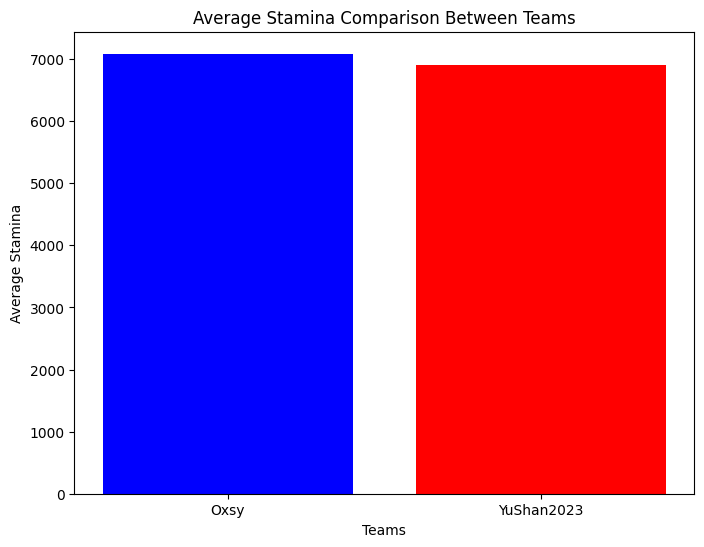

In [36]:
teams = [team_name_left, team_name_right]
total_stamina_avg = [total_stamina_avg_l, total_stamina_avg_r]

plt.figure(figsize=(8, 6))
plt.bar(teams, total_stamina_avg, color=['blue', 'red'])
plt.xlabel('Teams')
plt.ylabel('Average Stamina')
plt.title('Average Stamina Comparison Between Teams')
plt.show()

Uma forma melhor de visualizar o gasto médio de stamina é por meio de um box plot ou um gráfico de caixa.

No gráfico, a haste vertical é interpretada de baixo para cima, sendo que a parte inferior indica o mínimo e a superior indica o máximo, sempre desconsiderando possíveis outliers.

O retângulo central da haste possui três linhas que estão na horizontal: a linha de baixo, representada pelo contorno externo inferior do retângulo, indica o primeiro quartil. A linha de cima, que é o contorno externo superior do retângulo, indica o terceiro quartil. Já a linha interna indica a mediana ou o chamado segundo quartil.

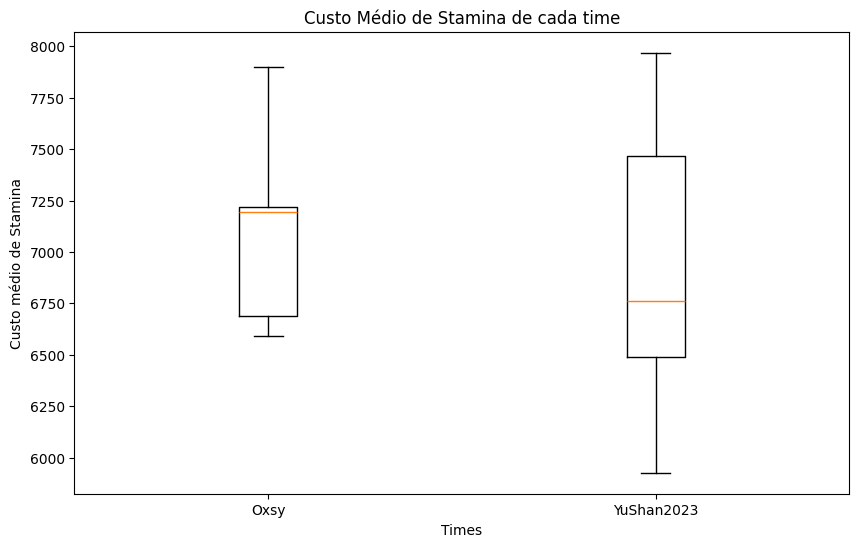

In [47]:
data = [stamina_avg_l, stamina_avg_r]

labels = [team_name_left, team_name_right]

plt.figure(figsize=(10, 6))
plt.boxplot(data, tick_labels=labels)
plt.xlabel('Times')
plt.ylabel('Custo médio de Stamina')
plt.title('Custo Médio de Stamina de cada time')
plt.show()

### Referências

- [(Artigo) A Data Analysis Graphical user Interface for RoboCup 2D Soccer Simulation League](https://ieeexplore.ieee.org/document/9307104)
- [SoccerAnalyser](https://github.com/robocin/SoccerAnalyzer)
- [Python Datascience Handbook](https://github.com/jakevdp/PythonDataScienceHandbook/blob/8a34a4f653bdbdc01415a94dc20d4e9b97438965/notebooks/Index.ipynb)
- [Expected goals: Understand the math behind it](https://datascientest.com/en/expected-goals-understand-the-math-behind-it)
- [Metodologia CRISP-DM](https://pt.wikipedia.org/wiki/Cross_Industry_Standard_Process_for_Data_Mining)
- [What is Data Analysis? An Expert Guide With Examples](https://www.datacamp.com/blog/what-is-data-analysis-expert-guide)